In [13]:
import numpy as np
import os
import statistics as stat
import math
import scipy as sci
from matplotlib import pyplot as plt
import PrizmCalibration as cl
#import prizmatoid as pzt
try:
    #reload(pzt)
    reload(cl)
except:
    from importlib import reload
    #reload(pzt)
    reload(cl)

In [14]:
flow = 60
fhigh = 120
minperbin = 10

# Prepping Data (don't need to do if using saved arrays)

In [15]:
cl.GSM_calibration_data(minperbin, flow, fhigh, 100, 'EW')

AttributeError: module 'PrizmCalibration' has no attribute 'GSM_calibration_data'

# Opening saved data

In [6]:
with open('100MHz_EW_antenna_average.npy', 'rb') as f:
    alldataavg = np.load(f)
with open('100MHz_EW_GSM_average.npy', 'rb') as g:
    allgsmavg = np.load(g)
with open('100MHz_EW_antenna_allarrays.npy', 'rb') as h:
    alldata = np.load(h)

FileNotFoundError: [Errno 2] No such file or directory: '100MHz_EW_antenna_average.npy'

# LEAST SQUARES


Text(0, 0.5, 'Temperature [K?]')

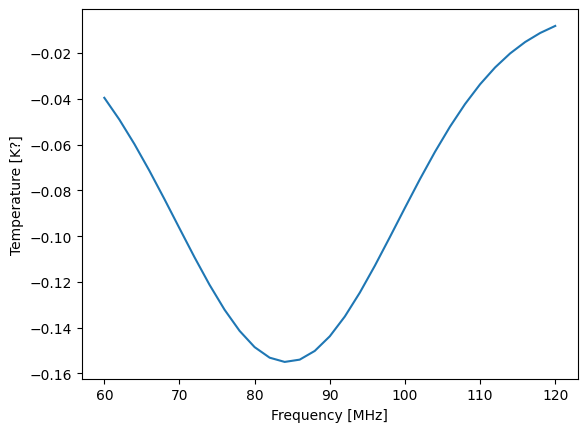

In [12]:
#Tcd simulation values (Note by Laurie (2024/01/16): "cd" as in "Cosmic Dawn" maybe?)
flow = 60
fhigh = 120

Tcd = np.array([-1.01879219e-02, -1.38655564e-02, -1.85246433e-02, -2.42953560e-02, -3.12793370e-02, -3.95323534e-02, -4.90465721e-02, -5.97345379e-02,
 -7.14172654e-02, -8.38188667e-02, -9.65697732e-02, -1.09219830e-01, -1.21261418e-01, -1.32161405e-01, -1.41399382e-01, -1.48508474e-01,
 -1.53114322e-01, -1.54967725e-01, -1.53966968e-01, -1.50167074e-01, -1.43774789e-01, -1.35129950e-01, -1.24675568e-01, -1.12920281e-01,
 -1.00397618e-01, -8.76265518e-02, -7.50773434e-02, -6.31455762e-02, -5.21360139e-02, -4.22565052e-02, -3.36209660e-02, -2.62595729e-02,
 -2.01338111e-02, -1.51539266e-02, -1.11965758e-02, -8.12093687e-03, -5.78213066e-03, -4.04138781e-03, -2.77289876e-03, -1.86766232e-03,
 -1.23487660e-03, -8.01511254e-04, -5.10689051e-04, -3.19421635e-04, -1.96125006e-04, -1.18212246e-04, -6.99443807e-05, -4.06259985e-05,
 -2.31641370e-05, -1.29654938e-05, -7.4827469e-06])

start = int((flow-50)/2)
end = 51-int((150-fhigh)/2)
Tcd = Tcd[start:end]
plt.plot(np.linspace(flow,fhigh,len(Tcd)),Tcd)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [K?]')

In [9]:
### create data to fit model to (d = Tgsm + Tcd)
d = allgsmavg + np.repeat(Tcd[np.newaxis,:], allgsmavg.shape[0], axis = 0)

NameError: name 'allgsmavg' is not defined

# Dealing with N

In [27]:
#find variance in power at one frequency over the 25 days of data
tmp = []
alldatavar = np.zeros((alldata.shape[1], alldata.shape[2]))

for j in range(0, alldata.shape[1]):
    for k in range(0, alldata.shape[2]):
        for i in range(0, alldata.shape[0]):
            if alldata[i,j,k] != 0:
                tmp.append(alldata[i,j,k])
        alldatavar[j, k] = np.nanvar(tmp)
        tmp = []

In [28]:
#find variance in power
timevar = np.nanvar(alldataavg, axis = 0)
freqvar = np.nanvar(alldataavg, axis=1)

# Fit versus t at each f

In [29]:
polydim = 8
a = np.zeros((polydim, alldataavg.shape[1]))

for j in range(0, alldataavg.shape[1]):
        Ninv = np.identity(144)*(1/alldatavar[:,j])
        P = alldataavg[:,j]
        columns = np.zeros((len(P), polydim))
        columns[:,0] = P
        for k in range(1, polydim):
            temparray = np.zeros(len(P))
            for i in range(0, alldataavg.shape[0]):
                temparray[i]= P[i]*(i*120)**k
            columns[:,k] = temparray  
        data = np.stack(columns, axis=0)
        data[np.isnan(data)] = 0
        
        d[np.isnan(d)] = 0
        AT = np.transpose(data)
        first = np.matmul(np.matmul(AT, Ninv), data)
        firstinv = np.linalg.inv(first)
        second = np.matmul(np.matmul(AT, Ninv), d[:,j])
        final = np.matmul(firstinv, second)  
        a[:,j] = final       

In [30]:
ktmp = np.zeros((alldataavg.shape[0], alldataavg.shape[1], polydim))
for i in range(0,alldataavg.shape[0]):
    for j in range(0,alldataavg.shape[1]):
        for l in range(0, polydim):
            ktmp[i,j,l] = a[l,j]*((i*120)**l)
k = np.nansum(ktmp, axis=2)
kavg = np.nanmean(k, axis=0)

([<matplotlib.axis.XTick at 0x128bfe410>,
 [Text(0, 0, '60'), Text(10, 0, '80'), Text(20, 0, '100'), Text(30, 0, '120')])

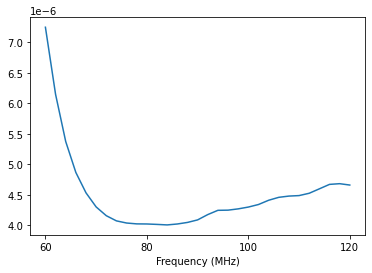

In [31]:
plt.plot(abs(kavg))
plt.xlabel('Frequency (MHz)')
labels=(["60", "80", "100", "120"])
plt.xticks([0, 10, 20, 30], labels)

In [32]:
obs = k*alldataavg
obs=np.nanmean(obs, axis=0)
v = []
for j in range(flow, fhigh+2, 2):
    v.append(j)
v=np.array(v)
fit = np.polyfit(np.log10(v/100), np.log10(np.abs(obs)), polydim)    
power = np.zeros(int((fhigh-flow)/2)+1)
i = 0
while i <= polydim:
    power = power + fit[polydim-i]*(np.log10(v/100))**i
    i += 1
y = 10**(power)

Text(0.5, 0, 'Frequency (MHz)')

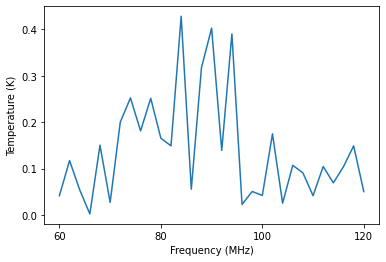

In [33]:
#plt.plot(y, label = 'Sky Model')
#plt.plot(obs,lw = 3, ls = ":", label = 'Observed Data')
plt.plot(abs(np.abs(y) - np.abs(obs)))
labels=(["60", "80", "100", "120"])
plt.xticks([0, 10, 20, 30], labels)
plt.ylabel('Temperature (K)')
plt.xlabel('Frequency (MHz)')
#plt.legend(loc = 'upper right', prop ={'size': 16})

# Fit versus f at each t

In [34]:
polydim = 8
a = np.zeros((polydim,alldataavg.shape[0]))

for j in range(0, alldataavg.shape[0]):
    Ninv = np.identity(alldataavg.shape[1])*(1/alldatavar[j,:])
    P = alldataavg[j,:]
    columns = np.zeros((len(P), polydim))
    columns[:,0] = P
    for k in range(1, polydim):
        temparray = np.zeros(len(P))
        for i in range(0, alldataavg.shape[1]):
            temparray[i]= P[i]*(i*2)**k
        columns[:,k] = temparray  
    data = np.stack(columns, axis=0)
    data[np.isnan(data)] = 0   
        
    d[np.isnan(d)] = 0
    AT = np.transpose(data)
    first = np.matmul(np.matmul(AT, Ninv), data)
    firstinv = np.linalg.inv(first)
    second = np.matmul(np.matmul(AT, Ninv), d[j,:])
    final = np.matmul(firstinv, second)  
    a[:,j] = final 

In [35]:
ktmp = np.zeros((alldataavg.shape[0],alldataavg.shape[1], polydim))
for i in range(0,alldataavg.shape[1]):
    for j in range(0,alldataavg.shape[0]):
        for l in range(0, polydim):
            ktmp[j,i,l] = a[l,j]*((i*2)**l)
k = np.nansum(ktmp, axis=2)
kaverage = np.average(k, axis=0)


([<matplotlib.axis.XTick at 0x129334850>,
 [Text(0, 0, '60'), Text(10, 0, '80'), Text(20, 0, '100'), Text(30, 0, '120')])

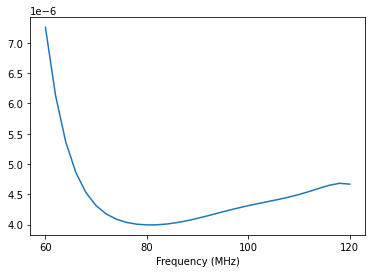

In [36]:
plt.plot(kaverage)
plt.xlabel('Frequency (MHz)')
labels=(["60", "80", "100", "120"])
plt.xticks([0, 10, 20, 30], labels)

In [37]:
obsall = k*alldataavg
obs=np.nanmean(obsall, axis=0)
v = []
for j in range(flow, fhigh+2, 2):
    v.append(j)
v=np.array(v)
fit = np.polyfit(np.log10(v/100), np.log10(np.abs(obs)), polydim)    
power = np.zeros(int((fhigh-flow)/2)+1)
i = 0
while i <= polydim:
    power = power + fit[polydim-i]*(np.log10(v/100))**i
    i += 1
y = 10**(power)

([<matplotlib.axis.XTick at 0x12923c450>,
 [Text(0, 0, '60'), Text(10, 0, '80'), Text(20, 0, '100'), Text(30, 0, '120')])

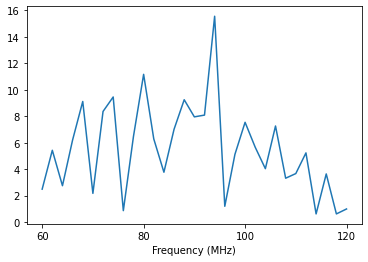

In [38]:
#plt.plot(y)
#plt.plot(obs)
plt.plot(abs(np.abs(y) - np.abs(obs)))
plt.xlabel('Frequency (MHz)')
labels=(["60", "80", "100", "120"])
plt.xticks([0, 10, 20, 30], labels)